In [1]:
import pandas as pd
import numpy as np
import itertools
import pprint
from collections import Counter
import networkx as nx
from networkx.algorithms import bipartite
from scipy.optimize import curve_fit 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import csv
import json
#import community as community_louvain
import networkx.algorithms.community as community
from sklearn import preprocessing

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_colwidth', None)

In [2]:
# upload data
df1 = pd.read_csv('full_dataset.csv', delimiter=';')
df2 = pd.read_csv('full_dataset_v2.csv', delimiter=';')
df3 = pd.read_csv('full_dataset_v3.csv', delimiter=';')

In [3]:
# union all 3 DFs and remove duplications
df = pd.concat([df1, df2, df3]).reset_index()
df = df.drop_duplicates(subset=["title", "id_stack", "tags", "views", "score", "done", "label"])
df.shape

(75334, 8)

In [4]:
df['id_stack'] = df['id_stack'].astype('category')
df['views'] = df['views'].astype('int32')
df['score'] = df['score'].astype('int32')

In [5]:
df = df[df['views'] >= 50].copy()
print(df.shape)

(15662, 8)


In [6]:
df.head()

,index,title,id_stack,tags,views,score,done,label
37,37,How do I draw this shape in Turtle?,61820846,"['python', 'turtle-graphics', 'python-turtle']",126,1,True,python
44,44,Dynamic Programming - Fibonacci,34055512,"['python', 'dynamic', 'fibonacci']",5232,3,True,python
54,54,Fastest way to convert a dict&#39;s keys &amp; values from `unicode` to `str`?,1254454,"['python', 'casting', 'types']",100959,79,True,python
60,60,Does Python have a ternary conditional operator?,394809,"['python', 'operators', 'ternary-operator', 'conditional-operator']",1899839,5997,True,python
66,66,Detect if X11 is available (python),1027894,"['python', 'user-interface']",3016,6,True,python


In [7]:
df.sort_values('id_stack', ascending = True, inplace = True)

In [8]:
df.dtypes

index          int64
title         object
id_stack    category
tags          object
views          int32
score          int32
done            bool
label         object
dtype: object

In [9]:
df.describe(include='all')

,index,title,id_stack,tags,views,score,done,label
count,15662.000000,15662,15662.000000,15662,15662.000000,15662.000000,15662,15662
unique,nan,15662,15662.000000,11760,nan,nan,2,5
top,nan,Error when using predict() function on caret models in R,123.000000,['java'],nan,nan,True,java
freq,nan,1,1.000000,199,nan,nan,12218,4220
mean,37801.148640,NaN,nan,NaN,40254.909207,36.334312,NaN,NaN
std,21662.482139,NaN,nan,NaN,183139.703595,225.778859,NaN,NaN
min,37.000000,NaN,nan,NaN,50.000000,-82.000000,NaN,NaN
25%,18904.250000,NaN,nan,NaN,193.000000,0.000000,NaN,NaN
50%,38105.000000,NaN,nan,NaN,1996.500000,2.000000,NaN,NaN
75%,56671.500000,NaN,nan,NaN,14000.500000,10.000000,NaN,NaN


In [10]:
 df.isnull().sum()

index       0
title       0
id_stack    0
tags        0
views       0
score       0
done        0
label       0
dtype: int64

In [11]:
label_list = list(set(df['label']))
print(label_list)

['javascript', 'php', 'R', 'python', 'java']


In [12]:
# an helper function for the similarity corr
def tags_to_list(tags):
    chars_to_remove= ["'", "[", "]", '"',' ']
    sc = set(chars_to_remove)
    res = ''.join([c for c in tags if c not in sc]).split(',')
    return res

In [13]:
full_tag_list = []
for i, record in df.iterrows():
    #full_tag_list += list(record['tags'])
    a = tags_to_list(record['tags'])
    full_tag_list += a

In [14]:
list_of_tags=pd.DataFrame(set(full_tag_list),columns=['Tag'])
list_of_tags.sort_values('Tag', ascending = True, inplace = True)

In [15]:
list_of_tags.head(1000)

,Tag
3041,.htaccess
5067,.net
1066,.net-4.5
169,.net-core
1858,2d
...,...
164,control-c
237,controller
2154,controller-advice
878,conv-neural-network


In [16]:
stack_nodes = df[["id_stack","title", "views", "score", "done", "label"]].copy()
stack_nodes = stack_nodes.rename(columns={'id_stack': 'id', 'title': 'label', 'label': 'language'})
stack_nodes.head()

,id,label,views,score,done,language
14032,123,Java lib or app to convert CSV to XML file?,73270,111,True,java
155120,146,How do I track file downloads,18855,78,True,php
66047,2933,How can I create a directly-executable cross-platform GUI app using Python?,165682,263,True,python
144822,5855,Automate builds for Java RCP for deployment with JNLP,989,9,True,java
27316,18985,How can I beautify JavaScript code using Command Line?,71824,98,True,javascript


In [17]:
# for performance we want to avoid accessing dataframes so we store relevant information in dicts 
id_stack_tags_dict = {}
id_stack_label_dict = {}
for i, record in df.iterrows():
    id_stack_tags_dict[record['id_stack']] = set(tags_to_list(record['tags']))
    id_stack_label_dict[record['id_stack']] = record['label']

In [18]:
# 5 different networks for the threshold analysis
network_dict_0 = {}
network_dict_2 = {}
network_dict_4 = {}
network_dict_6 = {}
network_dict_8 = {}

In [19]:
# the main FOR loop - calculating all the edges based on the chosen similarity metric - jaccard index
# and insert the data to the different dictionaries based on the thresholds
id_stack_list = df['id_stack'].tolist()
nodes_pairs = set()
edges_list = []
threshold = 0.6
max_corr = 0
for node in id_stack_list:
    node_tag = id_stack_tags_dict[node]
    network_dict_0[node] = []
    network_dict_2[node] = []
    network_dict_4[node] = []
    network_dict_6[node] = []
    network_dict_8[node] = []
    for neighbor in id_stack_list:
        if node == neighbor: continue
        neighbor_tag = id_stack_tags_dict[neighbor]
        # corr by Dice coefficient: (not chosen finally as the similarity metric)
        # corr = float(len(node_tag.intersection(neighbor_tag)))/float(len(node_tag)+(neighbor_tag))
        # corr by Jaccard index: (with modification)
        # corr = float(len(node_tag.intersection(neighbor_tag)))/float(len(node_tag.union(neighbor_tag)))
        corr = float(len(node_tag.intersection(neighbor_tag))**2)/float(max(len(node_tag.union(neighbor_tag)),2))
        if corr > max_corr: max_corr = corr
        if corr == 0: 
            continue
        elif corr < 0.2:
            network_dict_0[node].append((neighbor,corr))
        elif corr < 0.4:
            network_dict_0[node].append((neighbor,corr))
            network_dict_2[node].append((neighbor,corr))            
        elif corr < 0.6:
            network_dict_0[node].append((neighbor,corr))
            network_dict_2[node].append((neighbor,corr))
            network_dict_4[node].append((neighbor,corr))     
        elif corr < 0.8:
            network_dict_0[node].append((neighbor,corr))
            network_dict_2[node].append((neighbor,corr))
            network_dict_4[node].append((neighbor,corr))     
            network_dict_6[node].append((neighbor,corr))
        else:
            network_dict_0[node].append((neighbor,corr))
            network_dict_2[node].append((neighbor,corr))
            network_dict_4[node].append((neighbor,corr))     
            network_dict_6[node].append((neighbor,corr))
            network_dict_8[node].append((neighbor,corr))
        pair = frozenset({node, neighbor})
        if pair in nodes_pairs or corr<=threshold: continue
        nodes_pairs.add(pair)
        edges_list.append([node, neighbor, corr])
        

In [20]:
# # writing the networks to json files
# with open('j_network_dict_0.json', 'w') as f:
#     json.dump(network_dict_0, f)
# with open('j_network_dict_2.json', 'w') as f:
#     json.dump(network_dict_2, f)
# with open('j_network_dict_4.json', 'w') as f:
#     json.dump(network_dict_4, f)
# with open('j_network_dict_6.json', 'w') as f:
#     json.dump(network_dict_6, f)
# with open('j_network_dict_8.json', 'w') as f:
#     json.dump(network_dict_8, f)

In [21]:
# # reading the networks from json files
# with open('j_network_dict_0.json') as f:
#     network_dict_0_r = json.load(f)
# with open('j_network_dict_2.json') as f:
#     network_dict_2_r = json.load(f)
# with open('j_network_dict_4.json') as f:
#     network_dict_4_r = json.load(f)
# with open('j_network_dict_6.json') as f:
#     network_dict_6_r = json.load(f)
# with open('j_network_dict_8.json') as f:
#     network_dict_8_r = json.load(f)

In [22]:
# for Gephi, inserting the data to csv files
stack_edges = pd.DataFrame(edges_list, columns =['Source','Target','Corr'])

In [23]:
stack_nodes.to_csv("stack_nodes.csv", index=False)
stack_edges.to_csv("stack_edges.csv", index=False)

# Thresholds

([<matplotlib.axis.XTick at 0x213aeae0d48>,
 <a list of 5 Text xticklabel objects>)

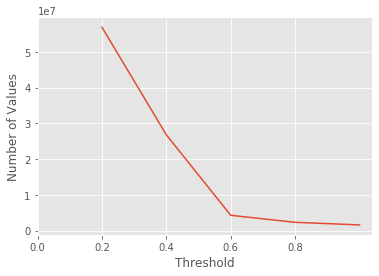

In [24]:
# create line chart for threshold analysis
a = (np.sum([ len(value) for (key,value) in network_dict_0.items()]))
b = (np.sum([ len(value) for (key,value) in network_dict_2.items()]))
c = (np.sum([ len(value) for (key,value) in network_dict_4.items()]))
d = (np.sum([ len(value) for (key,value) in network_dict_6.items()]))
e = (np.sum([ len(value) for (key,value) in network_dict_8.items()]))
values = [a,b,c,d,e]
x_axes = [0.2,0.4,0.6,0.8,1]
plt.plot(x_axes,values)
plt.xlabel('Threshold')
plt.ylabel('Number of Values')
plt.xticks(np.arange(0,1, 0.2))

([<matplotlib.axis.XTick at 0x215ab4697c8>,
 <a list of 4 Text xticklabel objects>)

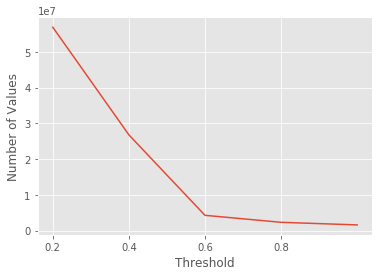

In [25]:
values = [a,b,c,d,e]
x_axes = [0.2,0.4,0.6,0.8,1]
plt.plot(x_axes,values)
plt.xlabel('Threshold')
plt.ylabel('Number of Values')
plt.xticks(np.arange(0.2,1, 0.2))

In [26]:
G0 = nx.Graph()
for node, list_neighbors in network_dict_0.items():
    for neighbor in list_neighbors:
        G0.add_edge(node, neighbor[0], weight=neighbor[1])

In [27]:
G2 = nx.Graph()
for node, list_neighbors in network_dict_2.items():
    for neighbor in list_neighbors:
        G2.add_edge(node, neighbor[0], weight=neighbor[1])

In [28]:
G4 = nx.Graph()
for node, list_neighbors in network_dict_4.items():
    for neighbor in list_neighbors:
        G4.add_edge(node, neighbor[0], weight=neighbor[1])

In [29]:
G6 = nx.Graph()
for node, list_neighbors in network_dict_6.items():
    for neighbor in list_neighbors:
        G6.add_edge(node, neighbor[0], weight=neighbor[1])

In [30]:
G8 = nx.Graph()
for node, list_neighbors in network_dict_8.items():
    for neighbor in list_neighbors:
        G8.add_edge(node, neighbor[0], weight=neighbor[1])

In [32]:
# threshold analysis plot_degree_dist
def thresh_plot_degree_dist(G0,G2,G4,G6,G8):
    degree_hist0 = nx.degree_histogram(G0)
    degree_hist0 = np.array(degree_hist0, dtype=float)
    degree_prob0 = degree_hist0/G0.number_of_nodes() 
    
    degree_hist2 = nx.degree_histogram(G2)
    degree_hist2 = np.array(degree_hist2, dtype=float)
    degree_prob2 = degree_hist2/G2.number_of_nodes()

    degree_hist4 = nx.degree_histogram(G4)
    degree_hist4 = np.array(degree_hist4, dtype=float)
    degree_prob4 = degree_hist4/G4.number_of_nodes()
    
    degree_hist6 = nx.degree_histogram(G6)
    degree_hist6 = np.array(degree_hist6, dtype=float)
    degree_prob6 = degree_hist4/G6.number_of_nodes()   
    
    degree_hist8 = nx.degree_histogram(G8)
    degree_hist8 = np.array(degree_hist8, dtype=float)
    degree_prob8 = degree_hist4/G8.number_of_nodes()      
    
    # plotting

    fig, axs = plt.subplots(5, sharex=True, sharey=True,figsize=(15,15))
    print('Threshold Degree Distribution')
    axs[0].loglog(np.arange(degree_prob0.shape[0]), degree_prob0,'.',  markersize=15, alpha=0.5)
    axs[0].set_title("Threshold 0.2")
    axs[0].set_ylabel("p(k)")
    axs[1].loglog(np.arange(degree_prob2.shape[0]), degree_prob2,'.',  markersize=15, alpha=0.5)
    axs[1].set_title("Threshold 0.4")
    axs[1].set_ylabel("p(k)")
    
    axs[2].loglog(np.arange(degree_prob4.shape[0]), degree_prob4,'.', markersize=15, alpha=0.5)
    axs[2].set_title("Threshold 0.6")
    axs[2].set_ylabel("p(k)")
    
    axs[3].loglog(np.arange(degree_prob6.shape[0]), degree_prob6, '.', markersize=15, alpha=0.5)
    axs[3].set_title("Threshold 0.8")
    axs[3].set_ylabel("p(k)")
    
    axs[4].loglog(np.arange(degree_prob8.shape[0]), degree_prob8, '.', markersize=15, alpha=0.5)
    axs[4].set_title("Threshold 1")
    plt.xlabel('k')
    plt.ylabel('p(k)')
 

Threshold Degree Distribution


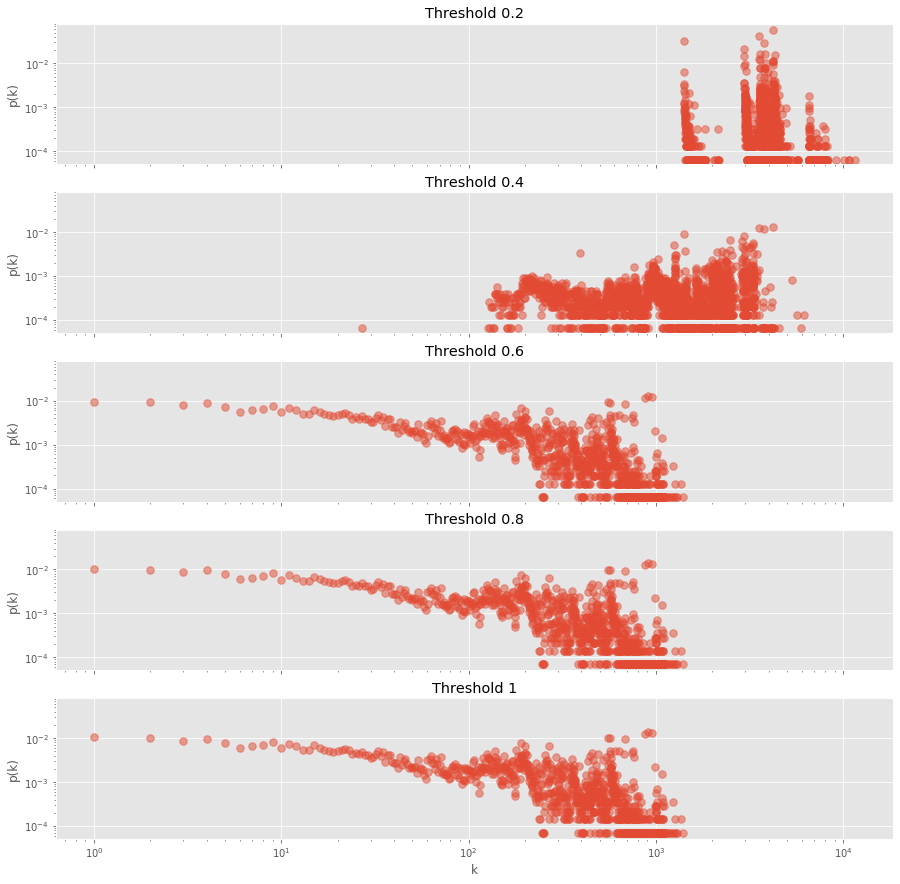

In [33]:
thresh_plot_degree_dist(G0,G2,G4,G6,G8)

In [34]:
# threshold analysis plot_weights_dist
def thresh_plot_weights_distribution(G0,G2,G4,G6,G8): 
    #0
    weighted_degree_hist = {}
    for node in G0.nodes():
        w_deg = G0.degree(node, weight='weight')
        if not w_deg in weighted_degree_hist:
            weighted_degree_hist[w_deg] = 1
        else:
            weighted_degree_hist[w_deg] += 1
    w_deg_lst0 = sorted(weighted_degree_hist.keys())

    w_deg_hist_lst = []
    for w_deg in w_deg_lst0:
        w_deg_hist_lst.append(weighted_degree_hist[w_deg])

    w_deg_hist_lst = np.array(w_deg_hist_lst, dtype=float)
    w_deg_prob0 = w_deg_hist_lst/G0.number_of_nodes()
    #2
    weighted_degree_hist = {}
    for node in G2.nodes():
        w_deg = G2.degree(node, weight='weight')
        if not w_deg in weighted_degree_hist:
            weighted_degree_hist[w_deg] = 1
        else:
            weighted_degree_hist[w_deg] += 1
    w_deg_lst2 = sorted(weighted_degree_hist.keys())

    w_deg_hist_lst = []
    for w_deg in w_deg_lst2:
        w_deg_hist_lst.append(weighted_degree_hist[w_deg])

    w_deg_hist_lst = np.array(w_deg_hist_lst, dtype=float)
    w_deg_prob2 = w_deg_hist_lst/G2.number_of_nodes()    
    
    #4
    weighted_degree_hist = {}
    for node in G4.nodes():
        w_deg = G4.degree(node, weight='weight')
        if not w_deg in weighted_degree_hist:
            weighted_degree_hist[w_deg] = 1
        else:
            weighted_degree_hist[w_deg] += 1
    w_deg_lst4 = sorted(weighted_degree_hist.keys())

    w_deg_hist_lst = []
    for w_deg in w_deg_lst4:
        w_deg_hist_lst.append(weighted_degree_hist[w_deg])

    w_deg_hist_lst = np.array(w_deg_hist_lst, dtype=float)
    w_deg_prob4 = w_deg_hist_lst/G4.number_of_nodes()    
    #6
    weighted_degree_hist = {}
    for node in G6.nodes():
        w_deg = G6.degree(node, weight='weight')
        if not w_deg in weighted_degree_hist:
            weighted_degree_hist[w_deg] = 1
        else:
            weighted_degree_hist[w_deg] += 1
    w_deg_lst6 = sorted(weighted_degree_hist.keys())

    w_deg_hist_lst = []
    for w_deg in w_deg_lst6:
        w_deg_hist_lst.append(weighted_degree_hist[w_deg])

    w_deg_hist_lst = np.array(w_deg_hist_lst, dtype=float)
    w_deg_prob6 = w_deg_hist_lst/G6.number_of_nodes()    
    #8
    weighted_degree_hist = {}
    for node in G8.nodes():
        w_deg = G8.degree(node, weight='weight')
        if not w_deg in weighted_degree_hist:
            weighted_degree_hist[w_deg] = 1
        else:
            weighted_degree_hist[w_deg] += 1
    w_deg_lst8 = sorted(weighted_degree_hist.keys())

    w_deg_hist_lst = []
    for w_deg in w_deg_lst8:
        w_deg_hist_lst.append(weighted_degree_hist[w_deg])

    w_deg_hist_lst = np.array(w_deg_hist_lst, dtype=float)
    w_deg_prob8 = w_deg_hist_lst/G8.number_of_nodes()



    # plotting  
    
    
    fig, axs = plt.subplots(5, sharex=True, sharey=True,figsize=(15,15))
    print('Threshold Weights Distribution')
    axs[0].loglog(w_deg_lst0,w_deg_prob0,'.', markersize=15, alpha=0.5)  
    axs[0].set_title("Threshold 0.2")
    axs[0].set_ylabel("p(w)")
    axs[1].loglog(w_deg_lst2,w_deg_prob2,'.',markersize=15, alpha=0.5)  
    axs[1].set_title("Threshold 0.4")
    axs[1].set_ylabel("p(w)")
    
    axs[2].loglog(w_deg_lst4,w_deg_prob4,'.', markersize=15, alpha=0.5)  
    axs[2].set_title("Threshold 0.6")
    axs[2].set_ylabel("p(w)")
    
    axs[3].loglog(w_deg_lst6,w_deg_prob6, '.',markersize=15, alpha=0.5)  
    axs[3].set_title("Threshold 0.8")
    axs[3].set_ylabel("p(w)")
    
    axs[4].loglog(w_deg_lst8,w_deg_prob8,'.', markersize=15, alpha=0.5)  
    axs[4].set_title("Threshold 1")
    plt.xlabel('w')
    plt.ylabel('p(w)')
 

Threshold Weights Distribution


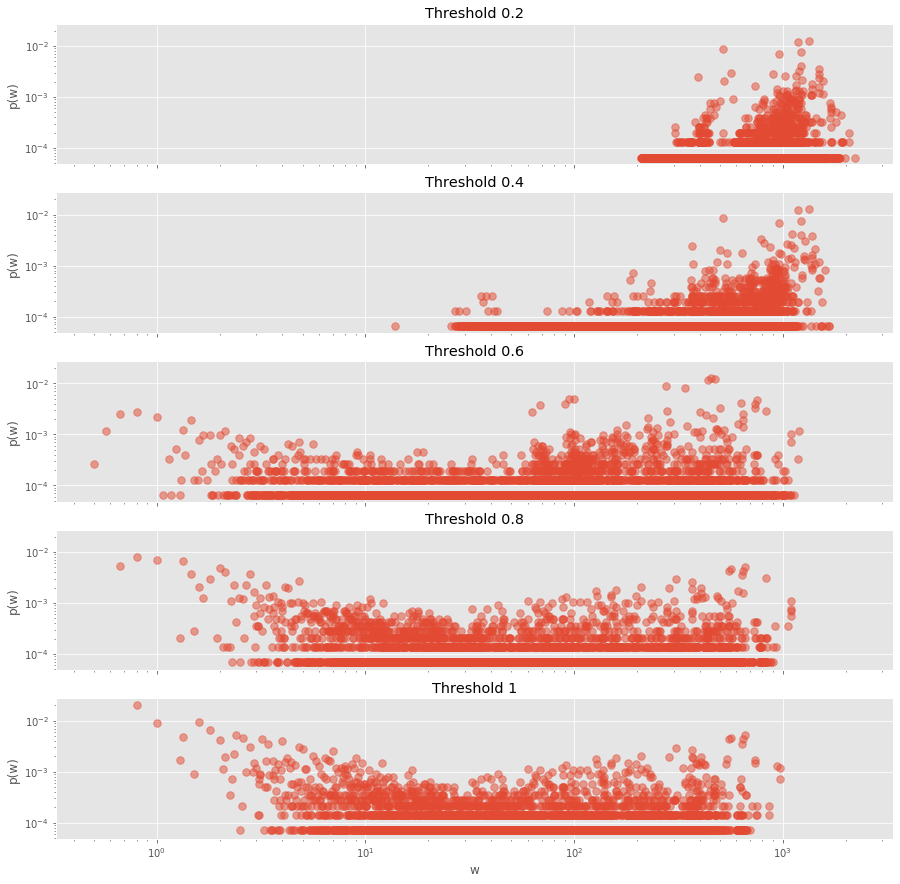

In [35]:
thresh_plot_weights_distribution(G0,G2,G4,G6,G8)

# Plots

In [36]:
#select G based on threshold analysis - threshold of 0.6
G = G4.copy()

In [37]:
def plot_degree_dist(G):
    degree_hist = nx.degree_histogram(G)
    degree_hist = np.array(degree_hist, dtype=float)
    degree_prob = degree_hist/G.number_of_nodes()
     # plotting\n",
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    axes.loglog(np.arange(degree_prob.shape[0]), degree_prob, '.', markersize=15, alpha=0.5)
    axes.set_xlabel('k')
    axes.set_ylabel('p(k)')
    axes.set_title('Degree Distribution')
    plt.show()

In [38]:
def plot_clustering_coefficient(G):
    clustering_dict = {}
    for node in G.nodes():
        k = G.degree(node)
        if k not in clustering_dict: clustering_dict[k] = []
        clustering_dict[k].append(nx.clustering(G,node))
    k_lst = sorted(clustering_dict.keys())
    clustering_lst = []
    for k in k_lst:
        #print(clustering_dict[k])
        clustering_lst.append(np.array(clustering_dict[k]).mean())
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    axes.loglog(k_lst,clustering_lst,'.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('C(k)')
    axes.set_title('Average clustering coefficient')
    
    plt.show()

In [39]:
def fit_func(x,a,mu):
    return (a*x)**mu

In [40]:
def plot_knn(G, fit=True): 
    knn_dict = nx.k_nearest_neighbors(G) # k_nearest_neighbors return dict with knn for each k
    k_lst = sorted(knn_dict.keys())
    knn_lst = []
    for k in k_lst:
        knn_lst.append(knn_dict[k])
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,knn_lst,'.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('knn(k)')
    axes.set_title('Average next neighbor degree')
    
    if fit:
        # fit a*x^mu
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(knn_lst))
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
    
    plt.show()

In [41]:
def plot_snn(G, fit=True): 
    snn_dict = nx.k_nearest_neighbors(G, weight='weight') 
    k_lst = sorted(snn_dict.keys())
    snn_lst = []
    for k in k_lst:
        snn_lst.append(snn_dict[k])
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,snn_lst,'.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('snn(k)')
    axes.set_title('Average next neighbor strength')
    
    if fit:
        # fit a*x^mu
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(snn_lst))
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
    
    plt.show()

In [42]:
def plot_weights_distribution(G): 
    
    weighted_degree_hist = {}
    for node in G.nodes():
        w_deg = G.degree(node, weight='weight')
        if not w_deg in weighted_degree_hist:
            weighted_degree_hist[w_deg] = 1
        else:
            weighted_degree_hist[w_deg] += 1
    w_deg_lst = sorted(weighted_degree_hist.keys())

    w_deg_hist_lst = []
    for w_deg in w_deg_lst:
        w_deg_hist_lst.append(weighted_degree_hist[w_deg])

    w_deg_hist_lst = np.array(w_deg_hist_lst, dtype=float)
    w_deg_prob = w_deg_hist_lst/G.number_of_nodes()
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(w_deg_lst,w_deg_prob,'.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('w')
    axes.set_ylabel('P(w)')
    axes.set_title('Weights Distribution')
    
    plt.show()

In [43]:
def print_attributes_and_plots(G):
    print(nx.info(G))
    if not nx.is_directed(G):
        if nx.is_connected(G):
            print ('Diameter: %s' % nx.diameter(G)) # print diameter of the network
        else:
            print ('Graph not connected: infinite path length')
            print ('Size of largest component: %s' % len(max(nx.connected_components(G), key=len)))
    print ('Degree Assortativity Coefficient (r): %s' % nx.degree_assortativity_coefficient(G))
    plot_degree_dist(G)
    plot_knn(G, fit=False)
    plot_snn(G, fit=False)
    if not nx.is_directed(G):
        plot_clustering_coefficient(G)
    plot_weights_distribution(G)

Name: 
Type: Graph
Number of nodes: 15519
Number of edges: 2137796
Average degree: 275.5069
Graph not connected: infinite path length
Size of largest component: 15499
Degree Assortativity Coefficient (r): 0.17302713575000242


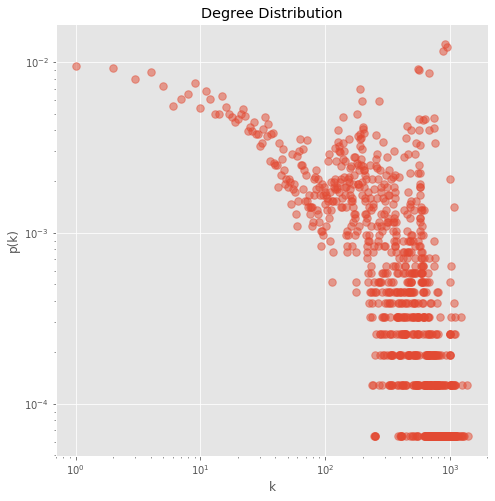

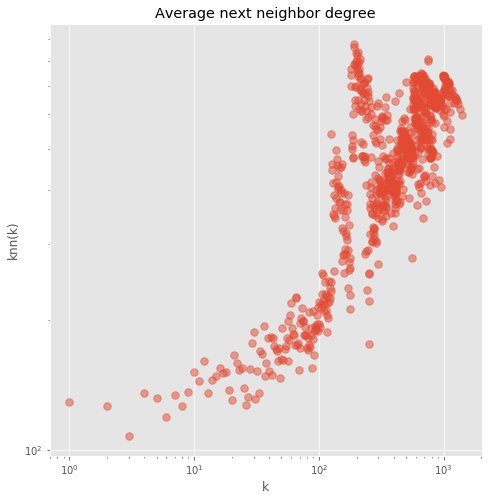

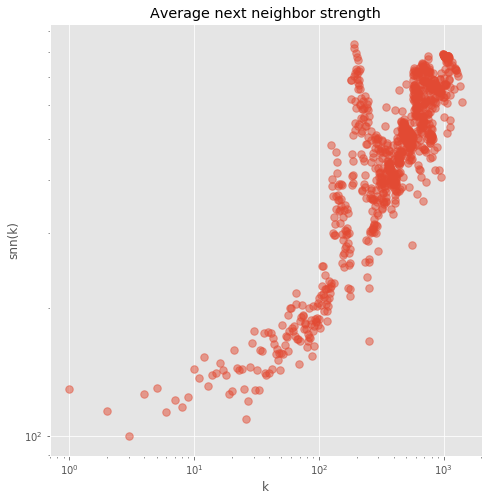

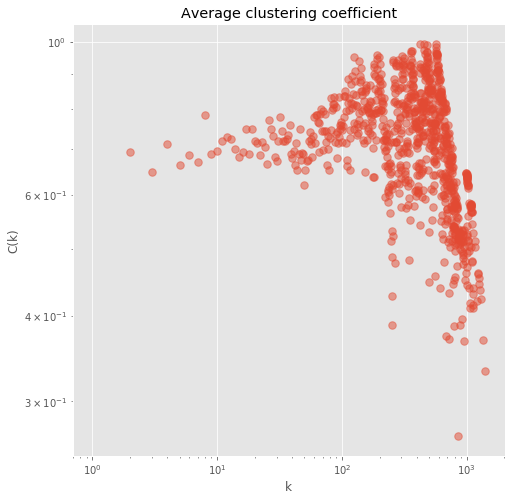

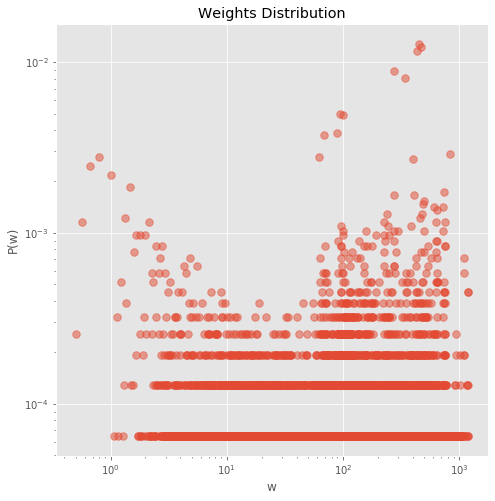

In [44]:
print_attributes_and_plots(G)

In [45]:
print(nx.average_clustering(G))

0.7452350689506758


### Centrality analysis
calculate centrality analysis by: page rank / degree / eigenvectors / betweenness / closeness

In [46]:
pr = nx.pagerank(G)

In [47]:
pr_top_ten = dict(sorted(pr.items(), key=lambda item: item[1],reverse=True)[:10])
print(pr_top_ten)
display(df[df['id_stack'].isin(pr_top_ten.keys())])

{22719118: 0.00018906401668963233, 48753272: 0.00018906401668963233, 51433092: 0.00018906401668963233, 16207575: 0.00018906401668963228, 20266219: 0.00018906401668963228, 62323626: 0.00018888156257901702, 61298910: 0.00018815272012865316, 31066693: 0.00017541907754691418, 19160218: 0.00017296095862725567, 48900700: 0.00017113977230723396}


,index,title,id_stack,tags,views,score,done,label
60284,32110,How to preview an image before and after upload?,16207575,"['php', 'javascript', 'jquery', 'html']",94757,23,True,javascript
25100,25100,Can I load the standard windows calculator using web tecnolgies,19160218,"['javascript', 'php', 'jquery', 'html', 'windows']",710,-1,False,php
79890,51716,Mobile number and message text checking,20266219,"['javascript', 'php', 'jquery', 'html']",2178,0,True,php
150462,70283,Disable page refresh after button click event,22719118,"['javascript', 'php', 'jquery', 'html']",6930,0,False,php
5071,5071,What is the purpose of the html form tag,31066693,"['javascript', 'php', 'jquery', 'html', 'forms']",15998,86,True,php
71016,42842,HTML form in php foreach loop table not getting output,48753272,"['javascript', 'php', 'jquery', 'html']",330,0,False,javascript
21291,21291,Execution default of goal org.springframework.boot:spring-boot-maven-plugin:1.4.0.RELEASE:repackage failed: Unable to rename,48900700,"['java', 'spring', 'maven', 'spring-boot']",4749,3,False,java
9319,9319,addEventListener to multiple checkboxes,51433092,"['javascript', 'php', 'jquery', 'html']",1990,3,True,php
71953,43779,"Objects Arrays, javascript. - JSON",61298910,"['javascript', 'php', 'jquery', 'html', 'json']",74,-1,False,php
143595,63416,how to change each buttons values in a loop with jquery,62323626,"['javascript', 'php', 'html', 'jquery', 'ajax']",50,0,True,php


In [48]:
ev = nx.eigenvector_centrality(G)

In [51]:
ev_top_ten = dict(sorted(ev.items(), key=lambda item: item[1],reverse=True)[:10])
print(ev_top_ten)
display(df[df['id_stack'].isin(ev_top_ten.keys())])

{61298910: 0.04509046166548501, 62323626: 0.04494725591056285, 31066693: 0.04479321838483576, 40958613: 0.044746109924773306, 49066624: 0.044732855417718174, 26320525: 0.04472825322764882, 19160218: 0.044727998980367244, 46392180: 0.044721101138699836, 16207575: 0.044718804468843486, 20266219: 0.044718804468843486}


,index,title,id_stack,tags,views,score,done,label
60284,32110,How to preview an image before and after upload?,16207575,"['php', 'javascript', 'jquery', 'html']",94757,23,True,javascript
25100,25100,Can I load the standard windows calculator using web tecnolgies,19160218,"['javascript', 'php', 'jquery', 'html', 'windows']",710,-1,False,php
79890,51716,Mobile number and message text checking,20266219,"['javascript', 'php', 'jquery', 'html']",2178,0,True,php
27333,27333,Prettify json data in textarea input,26320525,"['javascript', 'jquery', 'html', 'css', 'json']",67527,50,True,javascript
5071,5071,What is the purpose of the html form tag,31066693,"['javascript', 'php', 'jquery', 'html', 'forms']",15998,86,True,php
154519,74340,How to copy URL on button click?,40958613,"['javascript', 'php', 'jquery', 'html', 'web']",34655,4,True,javascript
139606,59427,Loading 1000 images on one page,46392180,"['javascript', 'php', 'jquery', 'html', 'lazy-loading']",101,2,True,php
135142,54963,Syntax Error &#39;SCRIPT1002&#39; using Internet Explorer 11,49066624,"['javascript', 'php', 'jquery', 'html', 'internet-explorer']",8140,3,True,javascript
71953,43779,"Objects Arrays, javascript. - JSON",61298910,"['javascript', 'php', 'jquery', 'html', 'json']",74,-1,False,php
143595,63416,how to change each buttons values in a loop with jquery,62323626,"['javascript', 'php', 'html', 'jquery', 'ajax']",50,0,True,php


In [53]:
#cc = nx.closeness_centrality(G)

In [54]:
#cc_top_ten = dict(sorted(cc.items(), key=lambda item: item[1],reverse=True)[:10])
##print(ev_top_ten)
#display(df[df['id_stack'].isin(cc_top_ten.keys())])

In [55]:
# saving the centrality analysis info
df[df['id_stack'].isin(pr_top_ten.keys())].to_csv("pr_top_ten.csv", index=False)
df[df['id_stack'].isin(ev_top_ten.keys())].to_csv("ev_top_ten.csv", index=False)
#df[df['id_stack'].isin(cc_top_ten.keys())].to_csv("cc_top_ten.csv", index=False)

In [56]:
g_degree = G.degree()

In [57]:
max_degree = sorted(g_degree, key=lambda x: x[1], reverse=True)[0]
print('max_degree: ', max_degree)

max_degree:  (62326624, 1403)


In [58]:
min_degree = sorted(g_degree, key=lambda x: x[1])[0]
print('min_degree: ', min_degree)

min_degree:  (5855, 1)


## Community Detection

In [59]:
# greedy modularity
greedy_modularity = community.greedy_modularity_communities(G)
print(greedy_modularity)

[frozenset({55984129, 62144514, 19161093, 53772300, 32276493, 14901265, 45563921, 36053014, 62455830, 37978138, 61972507, 62079004, 59686945, 58834978, 58794019, 32129060, 11354149, 43737126, 41123879, 61866023, 24870953, 62152751, 28663856, 32907314, 62079027, 27123763, 51609653, 46374966, 44335158, 62169144, 4317242, 48889914, 27803710, 29794369, 62210115, 27041862, 60137543, 51716168, 42623049, 60186698, 48963659, 24387660, 37765197, 61800526, 60596303, 61800528, 52133969, 52119454, 52117589, 59269208, 42516569, 56844378, 40575067, 62177372, 47497309, 62447710, 8290397, 2130016, 60579937, 46071906, 62349409, 29474916, 48914528, 62013538, 9642087, 61956199, 42008679, 24330346, 50937959, 53477475, 24346735, 53215355, 58548347, 49889403, 57327739, 1966207, 2736255, 12255359, 8806530, 61677696, 24977541, 33906822, 55550089, 47251594, 3391631, 59768976, 62374034, 60563604, 19439765, 61955566, 5628055, 622744, 37945495, 25387160, 62005403, 56483996, 62226589, 44761246, 57827485, 57893027,

In [60]:
a_sum  = 0
for l in greedy_modularity:
    a_sum +=len(l)
print(a_sum)

15519


In [61]:
greedy_modularity_rank = community.modularity(G, greedy_modularity)
print(greedy_modularity_rank)

0.7121995330451175


In [62]:
tags_df = df.copy()
tags_df.sort_values('label', ascending = True, inplace = True)

In [63]:
label_modularity = []
label = ''
label_set = set()
for i, record in tags_df.iterrows():
    id_label = record['label']
    id_stack = record['id_stack']
    if id_stack not in G.nodes(): continue
    if label != id_label:
        label_modularity.append(frozenset(label_set))
        label = id_label
        label_set = set()
    label_set.add(record['id_stack'])
label_modularity.append(frozenset(label_set))
label_modularity = label_modularity[1:]

In [64]:
label_modularity_rank = community.modularity(G, label_modularity)
print(label_modularity_rank)

0.7118190492710148


In [65]:
stack_nodes['greedy_modularity'] = None
greedy_modularity_dict = {}
for i, community in enumerate(greedy_modularity):
    for node in community: 
        mask = stack_nodes['id'] == node
        stack_nodes.loc[mask, 'greedy_modularity'] = i
        greedy_modularity_dict[node]= i

In [66]:
modularity_mapping = {'java':[2], 'javascript':[1], 'python':[0], 'php':[3],  }

In [67]:
# stack_nodes = stack_nodes.rename(columns={'id_stack': 'id', 'title': 'label', 'label': 'language'})
# calculating accuracy of greedy modularity v.s.label
correct_label_count = 0
for i, record in stack_nodes.iterrows():
    if record['language'] in modularity_mapping:
        if record['greedy_modularity'] in modularity_mapping[record['language']]: correct_label_count+=1
print(correct_label_count)

13004


In [68]:
modularity_accuracy = correct_label_count/stack_nodes.shape[0]
print('modularity_accuracy: ', modularity_accuracy)

modularity_accuracy:  0.830289873579364


In [69]:
nx.set_node_attributes(G, greedy_modularity_dict, 'greedy_modularity')

In [70]:
stack_nodes.to_csv("stack_nodes.csv", index=False)

In [71]:
# # girvan_newman
# girvan_newman = list(community.girvan_newman(G))
# # need to choose the number of communities you wish
# print(girvan_newman[5])

## The seconed (and flipped) network - The tags network:

In [72]:
tags_counter = Counter()
for i, record in df.iterrows():
    tags_set = set(tags_to_list(record['tags']))
    for tag in tags_set:
        tags_counter[tag] +=1
print(len(tags_counter))

6145


In [73]:
full_tag_list = []
id_stack_tags_dict = {}
for i, record in df.iterrows():
    #full_tag_list += list(record['tags'])
    a = tags_to_list(record['tags'])
    full_tag_list += a
    id_stack_tags_dict[record['id_stack']] = set(tags_to_list(record['tags']))

full_tag_list = set(full_tag_list)
print(len(full_tag_list))

6145


In [74]:
min_len = 5
tag_list = [k for k, v in tags_counter.items() if v >= min_len]
print(len(tag_list))

1200


In [75]:
tags_network_dict = {}
tags_nodes_pairs = set()
tags_edges_list = []
threshold = 0
for i, node in enumerate(tag_list):
    #print(i, ' ', node)
    tags_network_dict[node] = []
    node_qs = set([k for k, v in id_stack_tags_dict.items() if node in v])
    for neighbor in tag_list:
        if node == neighbor: continue
        neighbor_qs = set([k for k, v in id_stack_tags_dict.items() if neighbor in v])
        corr = len(node_qs.intersection(neighbor_qs))
        if corr > threshold: tags_network_dict[node].append((neighbor,corr))
        pair = frozenset({node, neighbor})
        if pair in tags_nodes_pairs or corr <= threshold: continue
        tags_nodes_pairs.add(pair)
        tags_edges_list.append([node, neighbor, corr])        

In [76]:
tags_nodes = pd.DataFrame(tag_list, columns =['id'])

In [77]:
tags_edges = pd.DataFrame(tags_edges_list, columns =['Source','Target','Corr'])

In [78]:
tags_nodes.to_csv("tags_nodes.csv", index=False)
tags_edges.to_csv("tags_edges.csv", index=False)

In [79]:
G_tags = nx.Graph()
for node, list_neighbors in tags_network_dict.items():
    for neighbor in list_neighbors:
        G_tags.add_edge(node, neighbor[0], weight=neighbor[1])

Name: 
Type: Graph
Number of nodes: 1200
Number of edges: 13424
Average degree:  22.3733
Diameter: 4
Degree Assortativity Coefficient (r): -0.20210474083880167


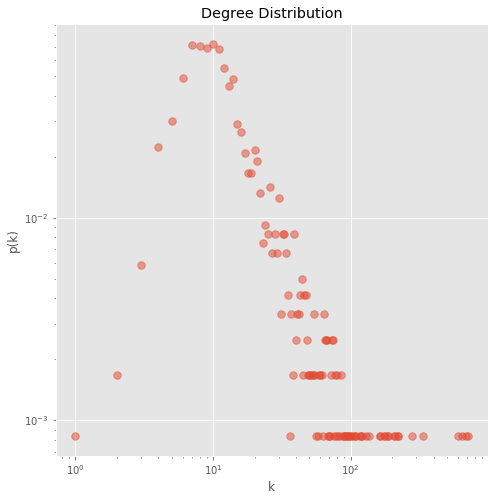

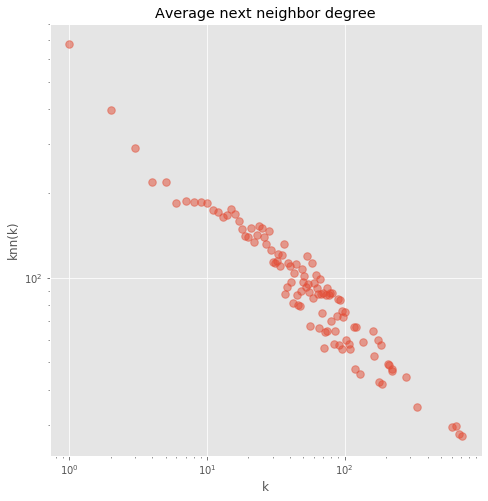

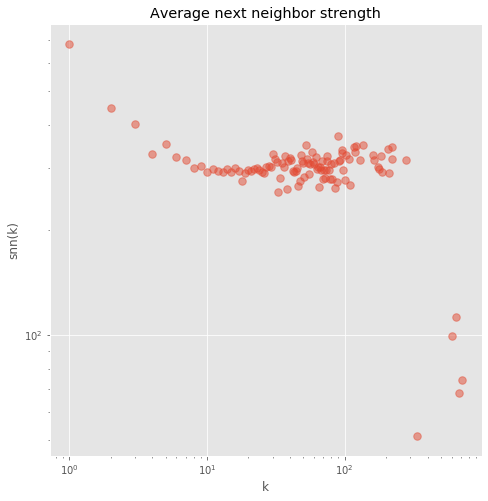

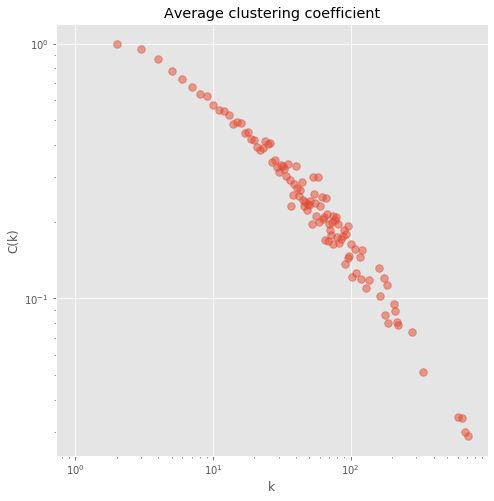

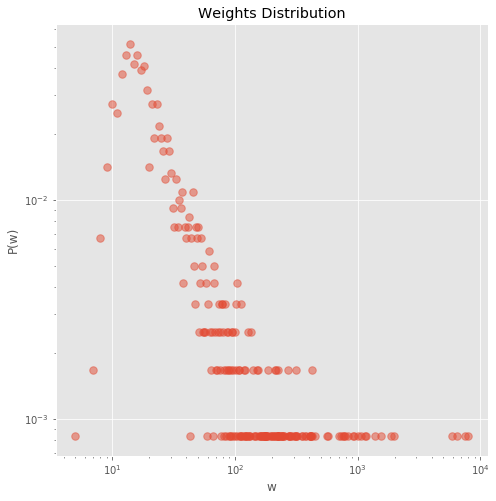

In [80]:
print_attributes_and_plots(G_tags)

In [81]:
G_tags_sorted = sorted(G_tags.degree(), key=lambda tup: tup[1], reverse=True)

[('java', 713), ('python', 682), ('javascript', 646), ('php', 602), ('r', 336), ('html', 279), ('android', 220), ('python-3.x', 219), ('node.js', 209), ('jquery', 207), ('laravel', 187), ('arrays', 185), ('spring', 178), ('mysql', 174), ('reactjs', 164), ('json', 162), ('django', 136), ('spring-boot', 129), ('string', 121), ('pandas', 118)]


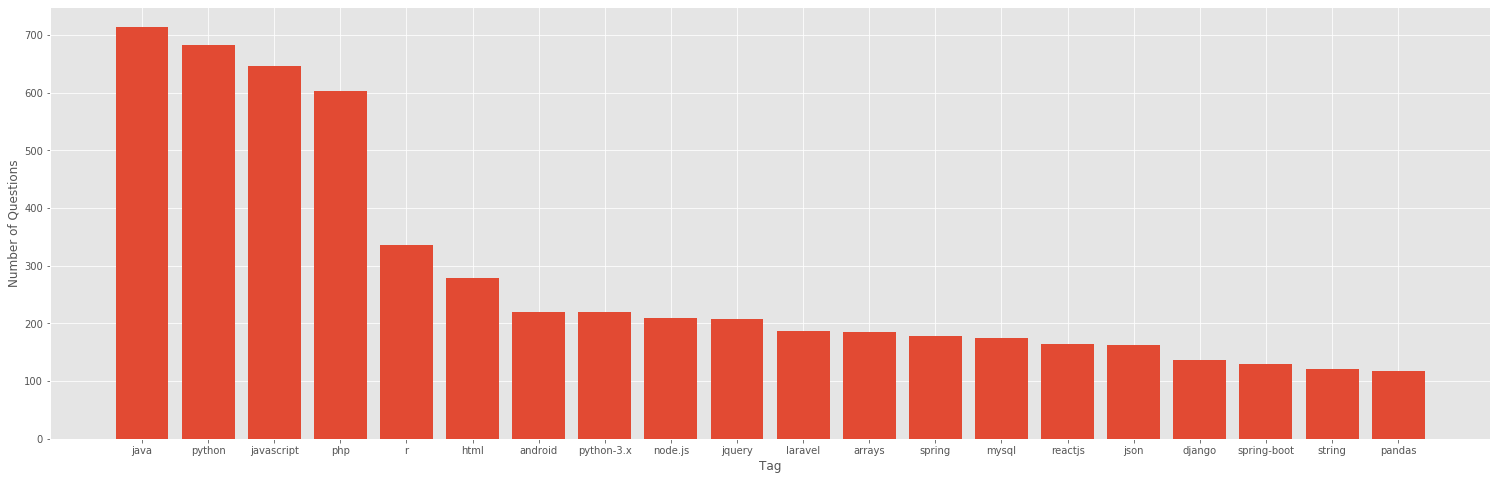

In [82]:
print(G_tags_sorted[:20])
fig = plt.figure(figsize=(20,6))
ax = fig.add_axes([0,0,1,1])
tags_axis = [tup[0] for tup in G_tags_sorted[:20]]
degree_axis = [tup[1] for tup in G_tags_sorted[:20]]
plt.xlabel('Tag')
plt.ylabel('Number of Questions')
plt.rcParams.update({'font.size': 17})
ax.bar(tags_axis,degree_axis)
plt.show()

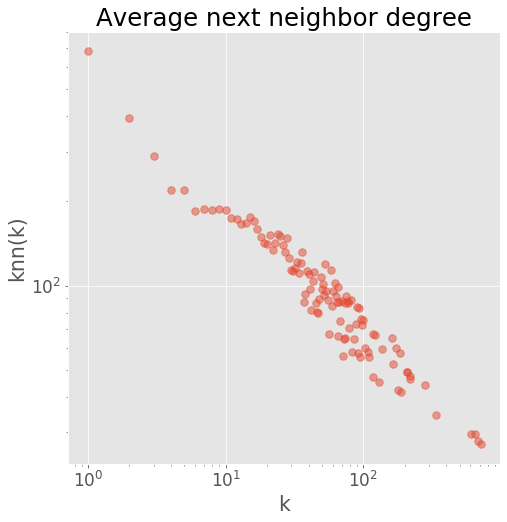

In [83]:
 plot_knn(G_tags, fit=False)